___
# **Starter code for BME 5710 project**
## Instructor -- Rizwan Ahmad (ahmad.46@osu.edu)
## BME5710 -- Spring 2024

___
### Import libraries and sub-libraries.

In [12]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
from skimage.metrics import structural_similarity as ssim
import tifffile 

___
### Calling a custom code to change the default font for figures to `Computer Modern`. (Optional)

In [13]:
from fontsetting import font_cmu
plt = font_cmu(plt)

___
### Check the hardware that is at your disposal

In [14]:
device = torch.device('gpu' if torch.cuda.is_available() else 'cpu')
print('Device available:', device)

Device available: cpu


___
### Read training & validation data from `data/train-clean-tif` and `data/val-clean-tif`


In [15]:
# Loading TIFF images
class TIFFDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.filenames = [f for f in os.listdir(directory) if f.endswith('.tif')]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.filenames[idx])
        image = Image.open(img_path)
        if self.transform: # Dynamically apply data transformation
            image = self.transform(image)
        return image

# Create a transform to convert the images to PyTorch tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the dataset for training images
train_dataset = TIFFDataset('train-clean-tif', transform=transform)

# Create the dataset for the validation images
val_dataset = TIFFDataset('val-clean-tif', transform=transform)

# Function to create data loader
def create_loader(train_dataset, batch_size):
    torch.manual_seed(0)  # For reproducibility of random numbers in PyTorch
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Creates a training DataLoader from this Dataset
    return train_loader

train_dataset_size = len(train_dataset)
print('Number of images in the train dataset:', train_dataset_size)

val_dataset_size = len(val_dataset)
print('Number of images in the validation dataset:', val_dataset_size)

Number of images in the train dataset: 52
Number of images in the validation dataset: 16


___
### Define a denoising network

#### Here, I have defined a trivial network, which has only one convolutional layer and no activation function. We are essentially doing linear filtering.

In [16]:
class TrivialNet(nn.Module):
    def __init__(self):
        super(TrivialNet, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [17]:
class DeNoise1(nn.Module):
  def __init__(self):
    super(DeNoise1, self).__init__()
    self.conv1 = nn.Sequential(
      nn.Conv2d(1, 64, kernel_size=(3,3), padding=(1,1)),
      nn.ReLU())
    #nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    # Rest of the layers remain the same
    self.conv2 = nn.Sequential(
      nn.Conv2d(64, 64, kernel_size=(3,3), padding=(1,1)),
      nn.ReLU())
    #nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    
    self.conv3 = nn.Sequential(
      nn.Conv2d(64, 128, kernel_size=(3,3), padding=(1,1)),
      nn.ReLU())
    self.conv4 = nn.Sequential(
      nn.Conv2d(128, 1, kernel_size=3, padding=1),
      nn.ReLU())
    
    self.up = nn.Upsample(size=4)

  def forward(self, x):
    x = self.conv1(x)
    # print(f"conv1: {x.shape}")
    x = self.conv2(x)
    # print(f"conv2: {x.shape}")
    x = self.conv3(x)
    # print(f"conv3: {x.shape}")
    # x = self.up(x)
    x = self.conv4(x)
    # print(f"conv4: {x.shape}")
    
    # print(f"up: {x.shape}")
    return x

___
### Define NMSE and SSIM functions

In [18]:
def calculateNMSE(true_img, noisy_img):
    mse = torch.mean((true_img - noisy_img) ** 2)
    nmse = mse / torch.mean(true_img ** 2)
    return nmse.detach().item()

def calculateSSIM(true_img, noisy_img):

    # TODO: fix this function
    true_img = np.abs(true_img.detach()).squeeze().numpy()
    noisy_img = np.abs(noisy_img.detach()).squeeze().numpy()
    img_range = np.max(true_img) - np.min(true_img)

    return ssim(true_img, noisy_img, data_range=img_range)
    

## Create function for adding noise

In [19]:
def add_mixed_noise(y_tr_batch, noise_std_gauss, noise_factor_speckle):
  """
  Adds mixed Gaussian and Speckle noise to a batch of images.

  Args:
      y_tr_batch: Torch tensor of images (assumes shape [batch_size, channels, height, width]).
      noise_std_gauss: Standard deviation for Gaussian noise.
      noise_factor_speckle: Factor controlling the intensity of Speckle noise.

  Returns:
      y_tr_batch_noisy: Torch tensor with added noise (same shape as input).
  """

  # Add Gaussian noise
  noise_gauss = torch.randn_like(y_tr_batch) * noise_std_gauss

  # Generate pepper and salt noise for Speckle noise (more suitable for images)
  noise_salt_pepper = torch.rand(y_tr_batch.size())  # Random between 0 and 1
  salt_mask = noise_salt_pepper < noise_factor_speckle * 0.5  # Set salt noise pixels
  pepper_mask = noise_salt_pepper > 1 - noise_factor_speckle * 0.5  # Set pepper noise pixels

  # Adjust pixel values for salt and pepper noise (white and black)
  noise_speckle = torch.where(salt_mask, 1.0, noise_salt_pepper)  # White noise for salt
  noise_speckle = torch.where(pepper_mask, 0.0, noise_speckle)  # Black noise for pepper

  # Combine both noise types
  y_tr_batch_noisy = y_tr_batch + noise_gauss + noise_speckle

  return y_tr_batch_noisy

___
### Create a function to execute training. Note, we will call this function later.

In [30]:
def train_model(model, opt, criterion, train_loader, val_loader, num_epoch, noise_std):
    avg_train_losses = []
    avg_nmse_losses = []
    val_nmse_per_epoch = []  # List to store validation NMSE per epoch

    avg_train_ssim_losses = [] 
    val_ssim_per_epoch = [] 

    for epoch in range(num_epoch):
        model.train()
        total_train_loss = 0
        total_nmse_loss = 0

        total_ssim_loss = 0

        for i, y_tr_batch in enumerate(train_loader):
            # Train with noisy data
            noise = torch.randn_like(y_tr_batch) * noise_std
            x_tr_batch = y_tr_batch + noise
            
            # rand_speckle = np.random.uniform(0.01, 0.05)
            # x_tr_batch = add_mixed_noise(y_tr_batch, 0.1, rand_speckle)

            opt.zero_grad()
            y_hat_tr_batch = model(x_tr_batch)
            # print(y_hat_tr_batch.shape)
            loss = criterion(y_hat_tr_batch, y_tr_batch)
            loss.backward()
            opt.step()
            # print(y_tr_batch.shape)
            total_train_loss += loss.item()

            # calculate loss of the batch
            for j in range(y_hat_tr_batch.shape[0]):
                total_nmse_loss += calculateNMSE(y_tr_batch[j], y_hat_tr_batch[j])
                total_ssim_loss += calculateSSIM(y_tr_batch[j], y_hat_tr_batch[j])

            if (i + 1) % 10 == 0:
                print(f'Epoch {epoch+1}, Iteration {i+1}, '
                      f'Loss: {loss.item():.6f}')

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_losses.append(avg_train_loss)
        avg_nmse_loss = total_nmse_loss / len(train_loader)
        avg_nmse_losses.append(avg_nmse_loss)
        avg_train_ssim_loss = total_ssim_loss / len(train_loader)
        avg_train_ssim_losses.append(avg_train_ssim_loss)

        # Calculate validation NMSE per epoch
        val_epoch_nmse = 0
        val_epoch_ssim = 0
        for y_val_batch in val_loader:
            noise_val = torch.randn_like(y_val_batch) * noise_std
            x_val_batch = y_val_batch.detach() + noise_val

            # rand_speckle = np.random.uniform(0.01, 0.05)
            # x_val_batch = add_mixed_noise(y_tr_batch, 0.1, rand_speckle)

            y_hat_val_batch = model(x_val_batch)
            # print(y_hat_val_batch.shape)
            for j in range(y_hat_val_batch.shape[0]):
                val_epoch_nmse += calculateNMSE(y_val_batch[j], y_hat_val_batch[j])
                val_epoch_ssim += calculateSSIM(y_val_batch[j], y_hat_val_batch[j])
        val_nmse_per_epoch.append(val_epoch_nmse / len(val_loader))
        val_ssim_per_epoch.append(val_epoch_ssim / len(val_loader))

    # Plotting (combine training and validation NMSE on same plot)
    fig, ax = plt.subplots(2,1,figsize=(7, 6))
    epochs = range(1, num_epoch + 1)  # X-axis for training NMSE

    # ax[0].plot(epochs, avg_train_losses, label='Training')

    # ax[0].set_xlabel('Epochs')
    # ax[0].set_ylabel('MSE Loss')
    # # No need for log scale here, adjust based on your needs
    # ax[0].set_title('Training MSE')
    # ax[0].grid(True)
    # ax[0].legend()

    ax[0].plot(epochs, avg_nmse_losses, label='Training')
    ax[0].plot(epochs, val_nmse_per_epoch, label='Validation')

    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('NMSE Loss')
    # No need for log scale here, adjust based on your needs
    ax[0].set_title('Training and Validation NMSE')
    ax[0].grid(True)
    ax[0].legend()

    ax[1].plot(epochs, avg_train_ssim_losses, label='Training')
    ax[1].plot(epochs, val_ssim_per_epoch, label='Validation')

    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('SSIM')
    # No need for log scale here, adjust based on your needs
    ax[1].set_title('Training and Validation SSIM')
    ax[1].grid(True)
    ax[1].legend()

    plt.tight_layout()
    plt.show()


___
### Now, let us define hyperparameters and train the network. 

#### Note, in addition to the parameters that controls the network architecture or the training process, you need to select/initialize (i) a data loader, (ii) a model, (iii) an optimizer, and (iv) a loss function.

Epoch 1, Iteration 10, Loss: 0.003357
Epoch 1, Iteration 20, Loss: 0.001943
Epoch 2, Iteration 10, Loss: 0.001627
Epoch 2, Iteration 20, Loss: 0.001562
Epoch 3, Iteration 10, Loss: 0.001257
Epoch 3, Iteration 20, Loss: 0.001135
Epoch 4, Iteration 10, Loss: 0.001203
Epoch 4, Iteration 20, Loss: 0.000992
Epoch 5, Iteration 10, Loss: 0.001173
Epoch 5, Iteration 20, Loss: 0.001191
Epoch 6, Iteration 10, Loss: 0.001144
Epoch 6, Iteration 20, Loss: 0.001169
Epoch 7, Iteration 10, Loss: 0.001121
Epoch 7, Iteration 20, Loss: 0.001001
Epoch 8, Iteration 10, Loss: 0.001174
Epoch 8, Iteration 20, Loss: 0.001003
Epoch 9, Iteration 10, Loss: 0.000853
Epoch 9, Iteration 20, Loss: 0.001180
Epoch 10, Iteration 10, Loss: 0.000947
Epoch 10, Iteration 20, Loss: 0.000863
Epoch 11, Iteration 10, Loss: 0.000827
Epoch 11, Iteration 20, Loss: 0.001043
Epoch 12, Iteration 10, Loss: 0.000924
Epoch 12, Iteration 20, Loss: 0.000974
Epoch 13, Iteration 10, Loss: 0.000993
Epoch 13, Iteration 20, Loss: 0.001048
Epoc

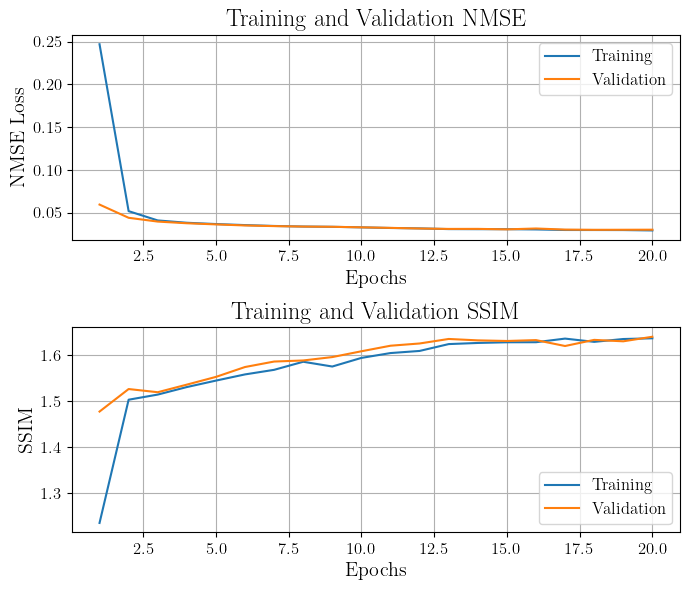

In [31]:
batch_size = 2 # Number of complete images in each batch
lr = 1e-3  # Learning rate
sig = 0.1  # Noise std
num_epoch = 20  # Epochs

# Model, criterion, and optimizer
train_loader = create_loader(train_dataset, batch_size)
val_loader = create_loader(val_dataset, batch_size)

model = DeNoise1() # Pick a model
opt = optim.Adam(model.parameters(), lr=lr) # Pick an optimizer
criterion = nn.MSELoss() # Pick a loss function

# Let's train the model
train_model(model, opt, criterion, train_loader, val_loader, num_epoch, noise_std=sig)

In [32]:
# save the model
PATH = 'denoise1_gauss.pt'
torch.save(model.state_dict(), PATH)

___
### Apply it to one of the validation image

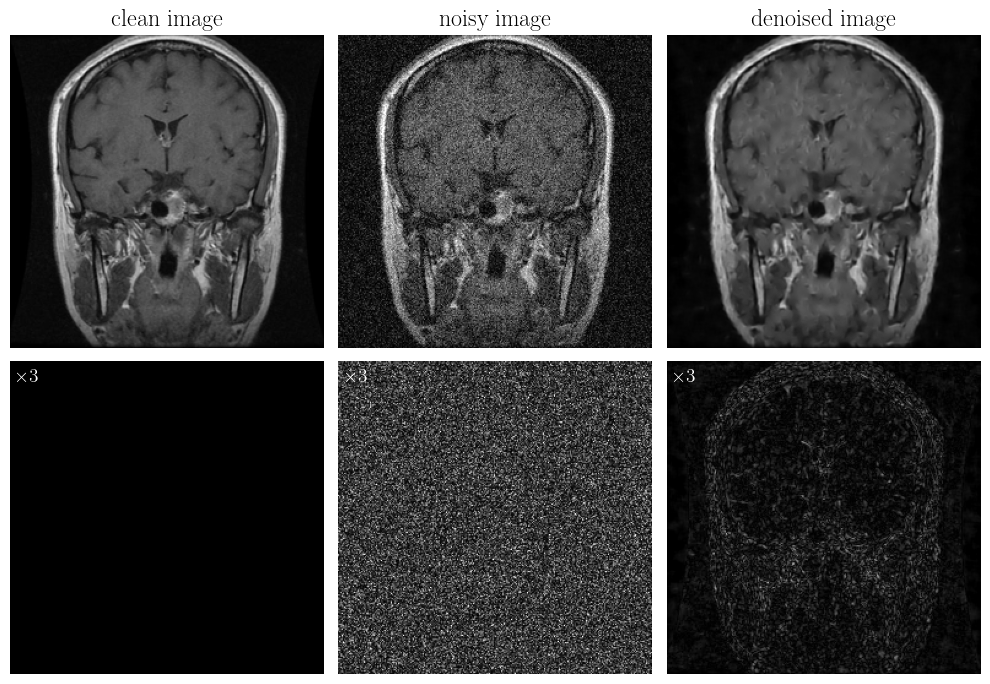

In [33]:
val_dataset = TIFFDataset('val-clean-tif', transform=transform) # Create the dataset for validation images
val_clean = val_dataset[0] # Load one clean image from the validation dataset
val_noisy = val_clean + (torch.randn_like(val_clean) * sig) # Add noise to the clean image
val_denoised = model(val_noisy).detach() # Denoise the noisy image using the trained model


# Your existing code to generate the figure and axes
fig, ax = plt.subplots(2, 3, figsize=(10, 7))

# Plot clean image
ax[0, 0].imshow(np.abs(val_clean).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 0].set_title('clean image')
ax[0, 0].axis('off')

# Plot noisy image
ax[0, 1].imshow(np.abs(val_noisy).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 1].set_title('noisy image')
ax[0, 1].axis('off')

# Plot denoised image
ax[0, 2].imshow(np.abs(val_denoised).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 2].set_title('denoised image')
ax[0, 2].axis('off')

# Plot corresponding error images
ax[1, 0].imshow(3*np.abs(val_clean - val_clean).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 0].axis('off')
ax[1, 0].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 0].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 1].imshow(3*np.abs(val_clean - val_noisy).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 1].axis('off')
ax[1, 1].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 1].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 2].imshow(3*np.abs(val_clean - val_denoised).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 2].axis('off')
ax[1, 2].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 2].transAxes, fontsize=14, va='top', ha='left', color='white')


plt.tight_layout()
plt.show()


In [ ]:
val_dataset = TIFFDataset('val-clean-tif', transform=transform) # Create the dataset for validation images
val_clean = val_dataset[0] # Load one clean image from the validation dataset
val_noisy = val_clean + (torch.randn_like(val_clean) * sig) # Add noise to the clean image
val_denoised = model(val_noisy) # Denoise the noisy image using the trained model

# Model Evaluation

In [34]:
calculateSSIM(val_clean, val_denoised)

0.819390670980692

In [35]:
snr = -20*np.log(calculateNMSE(val_clean, val_denoised))
snr

86.86908192999168

In [ ]:
calculateSSIM(val_clean, val_denoised)

## Things to try

### add metrics for validating model 

### use CNN architecture from HW 9

### transpose of matrix

### add more feature extraction (like edge detection)

### adding more random noise

### dimensionality reduction of images

### dense network

### create artificial testing set (with varying noise)

### use diffusion models